## Lab 10 Self practice

This self practice notebooks covers the concepts from the Lecture that we skipped during the lab:

 - Gradient clipping
 - Usage of different optimizers (Adam, SGD, RMSProp)
 - Usage of pretrained layers

# 1) Gradient clipping


This method is called alongside LR-scheduler and optimizer and may solve the problem of [gradients explosion](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/) by strict limitation of gradients by the given norm.


In this snippet you have a deal with artificially (ha-ha) impaired ANN: its weights are uniformly distributed within a wide range.

Train: 0.518, Test: 0.510


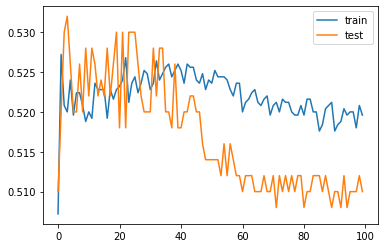

In [96]:
# Many thanks to Jason Brownlee https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/


# Two circles classification problem
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.initializers import RandomUniform
from matplotlib import pyplot

# Generate 2d classification dataset
X, Y = make_circles(n_samples=3000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-2, 2))
X = scaler.fit_transform(X)
# Split into train and test
n_train = 2500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainY, testY = Y[:n_train], Y[n_train:]

# Define model - simple MLP, but with possible big values of weights
init = RandomUniform(minval=-20, maxval=20, seed=42)
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer=init))
model.add(Dense(20, activation='relu', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

# Compile model
opt = SGD(learning_rate=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit model
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, verbose=0, batch_size = 200)

# Evaluate the model
_, train_acc = model.evaluate(trainX, trainY, verbose=0)
_, test_acc = model.evaluate(testX, testY, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

**Task 1.**


Do not modify any parameters except SGD. Look for the documentation (keras package), it has the parameters related to gradient clipping.


1) Try to run the training procedure several times as it is, without clipping. Is it stable? Is the classifier precise?


2) Choose one of the clipping parameters for SGD. How does it impact on loss? What figure have you chosen for the clip? If you got on plateau, probably clipping was too tough and you fall into the case when [all weights are equal](https://stackoverflow.com/questions/20027598/why-should-weights-of-neural-networks-be-initialized-to-random-numbers).


3) How would you improve searching for the best value of clip?


4) How is clipping implemented in PyTorch?

# 2) Optimizers


While gradient descent is a pretty well-known and efficient algorithm, sometimes for Deep NNs it's not sufficient, and the community proposed several modifications to make the convergence more stable and fast. The classical set of optimizers: SGD, RMSProp and Adam.


**Task 2**.


1) Return back to the previous snippet and replace init to


```
init = RandomUniform(minval=-3, maxval=3, seed=42)
```
Try to change SGD to Adam and RMSprop. Does it improve the loss? Try to do the same for the network from the Lab. Also try to set momentum=0.9 for SGD.


2*) Check [this](https://www.ruder.io/optimizing-gradient-descent/#otherrecentoptimizers) brilliant post with comparison of modern optimizers. It's not necessary to go through all of them, but you can read the "Challenges", "Momentum", "Adagrad", "Adam" and "Visualization of algorithms" sections. What's the purpose of momentum? How can learning rate be controlled in optimizers?

# 3) Fine Tuning of pre-trained models

Reuse of the models that were trained before might be a great idea - you don't waste a lot of time, and don't need to dig into all the tricks which people applied during the training of this model. Of course, usually such ANNs are trained on popular datasets which could be different from yours. However, if the datasets are similar to each other, you can fine-tune the model to your case, i.e. save the main part and train only the last layer(s). 

PyTorch and Keras deliver pretrained models right from the packages. For example, you can load weights of a ResNet model. ResNets are quite popular deep neural networks, and in PyTorch they are trained on [ImageNet](https://en.wikipedia.org/wiki/ImageNet) dataset (224x224 images divided into 1000 classes).

**Task 3.**

Load a pretrained ResNet-18 and fine-tune it to solve a classification task on CIFAR10. 


*Note. ResNet-18 is a much bigger model than those we trained before. You might need a GPU to train it. If you don't have it, please, use Colab.*

In [10]:
# Source https://github.com/hyunjoonbok/Python-Projects/blob/master/Pytorch/Transfer%20Learning%20in%20Pytorch%20by%20building%20CIFAR-10%20model.ipynb
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

    
batch_size = 32 


transform = transforms.Compose([
    transforms.Resize((224, 224)), # Input size pretrained model, we have to resize CIFAR images to it
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# With no data augmentation, but you can write another transform with 
# the methods that we used on lab
train_dataset = datasets.CIFAR10(root='./data', train=True, 
                                 transform=transform, download=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                 transform=transform, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                          num_workers=2, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, 
                         num_workers=2, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Set pretrained=True to download weights 
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Freezing the layers
for param in model.parameters():
    param.requires_grad = False

# Fine-tuning: replacement of some old layers by the appropriate ones
# Your code here: how to replace the last layer to match CIFAR10?
model.fc = ...
print(model)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Copy-paste of lab code
from time import time 
from tqdm import tqdm


def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    
    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        # Get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

In [17]:
from torch.optim import SGD
from torch.optim import lr_scheduler
from copy import deepcopy

# No need of many epochs
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2, verbose=True, min_lr=0.0001)


In [ ]:
def training():
    for epoch in range(0, epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)
        test_loss, test_acc = test(model, device, test_loader, criterion)
        print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
        print(f"Training loss {train_loss}, test loss {test_loss}")
        
    torch.save(model.state_dict(), "model.pt")
        
training()